In [4]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from openmeteo_requests import Client


# Liste des régions avec coordonnées
region_centroides =[('Guadeloupe', -61.53983304107784, 16.197645826552904),
 ('Guyane', -53.23993971851178, 3.915166862499844),
 ('Martinique', -61.019378740773654, 14.654870858984358),
 ('Mayotte', 45.14743542382146, -12.820616875536656),
 ('Auvergne-Rhône-Alpes', 4.536118586333609, 45.51464202656834),
 ('Occitanie', 2.143922833937654, 43.70250024549978),
 ('Bretagne', -2.841462676465886, 48.17754922086023),
 ('Nouvelle-Aquitaine', 0.21271860548694332, 45.2060395396088),
 ('Normandie', 0.11093239896467046, 49.12006667987373),
 ("Provence-Alpes-Côte d'Azur", 6.061004522552231, 43.95878857291765),
 ('Pays de la Loire', -0.81678598261894, 47.47810354487287),
 ('Grand Est', 5.613112231600144, 48.68897740160863),
 ('Bourgogne-Franche-Comté', 4.806856915301157, 47.2342819451994),
 ('Île-de-France', 2.503401392552759, 48.70931550109074),
 ('Centre-Val de Loire', 1.684391322381998, 47.48477508284454),
 ('Hauts-de-France', 2.7713028658475474, 49.969593961262426),
 ('Corse', 9.106151755156151, 42.15151137562012),
 ('La Réunion', 55.53250880056539, -21.133202961171154)]

# Création d'une session avec cache
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = Client(session=retry_session)

# Création d'un dictionnaire pour stocker les DataFrames
region_dataframes = {}

# Boucle pour récupérer les données pour chaque région
for region, longitude, latitude in region_centroides:
    try:
        url = "https://air-quality-api.open-meteo.com/v1/air-quality"
        params = {
            "latitude": latitude,
            "longitude": longitude,
            "current": ["european_aqi", "us_aqi"],
            "hourly": ["pm10", "pm2_5", "carbon_monoxide", "carbon_dioxide", "nitrogen_dioxide", "sulphur_dioxide", "ozone"],
            "start_date": "2023-11-01",
            "end_date": "2024-11-01"
        }

        responses = openmeteo.weather_api(url, params=params)
        response = responses[0]  # Première réponse, si plusieurs localisations

        # Récupération des données horaires
        hourly = response.Hourly()
        hourly_data = {
            "date": pd.date_range(
                start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=hourly.Interval()),
                inclusive="left"
            ),
            "region": [region] * len(pd.date_range(
                start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=hourly.Interval()),
                inclusive="left"
            )),
            "pm10": hourly.Variables(0).ValuesAsNumpy(),
            "pm2_5": hourly.Variables(1).ValuesAsNumpy(),
            "carbon_monoxide": hourly.Variables(2).ValuesAsNumpy(),
            "carbon_dioxide": hourly.Variables(3).ValuesAsNumpy(),
            "nitrogen_dioxide": hourly.Variables(4).ValuesAsNumpy(),
            "sulphur_dioxide": hourly.Variables(5).ValuesAsNumpy(),
            "ozone": hourly.Variables(6).ValuesAsNumpy()
        }

        # Stockage du DataFrame dans le dictionnaire
        region_dataframes[region] = pd.DataFrame(data=hourly_data)

    except Exception as e:
        print(f"Erreur lors de la récupération des données pour {region}: {e}")

# Concaténation tous les DataFrames
combined_dataframe = pd.concat(region_dataframes.values(), ignore_index=True)
combined_dataframe['date'] = pd.to_datetime(combined_dataframe['date'])
# Création d'une nouvelle colonne 'day' contenant uniquement la date (sans l'heure)
combined_dataframe['day'] = combined_dataframe['date'].dt.date
# Agrégation par 'day' et 'region' en prenant la moyenne
daily_dataframe = combined_dataframe.groupby(['day', 'region']).mean().reset_index()





[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\nouts\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\nouts\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
daily_dataframe

,day,region,date,pm10,pm2_5,carbon_monoxide,carbon_dioxide,nitrogen_dioxide,sulphur_dioxide,ozone
0,2023-11-01,Auvergne-Rhône-Alpes,2023-11-01 11:30:00+00:00,7.604167,4.312500,167.625000,NaN,6.758333,0.529167,40.416668
1,2023-11-01,Bourgogne-Franche-Comté,2023-11-01 11:30:00+00:00,6.387500,3.812500,163.166672,NaN,4.687500,0.433333,42.916668
2,2023-11-01,Bretagne,2023-11-01 11:30:00+00:00,8.012500,4.375000,154.250000,NaN,1.695833,0.233333,68.666664
3,2023-11-01,Centre-Val de Loire,2023-11-01 11:30:00+00:00,7.579166,3.837500,164.708328,NaN,1.887500,0.308333,56.625000
4,2023-11-01,Corse,2023-11-01 11:30:00+00:00,6.104167,2.750000,138.750000,NaN,1.958333,0.262500,61.916668
...,...,...,...,...,...,...,...,...,...,...
6601,2024-11-01,Nouvelle-Aquitaine,2024-11-01 11:30:00+00:00,17.166666,9.695833,141.583328,448.791656,3.529166,0.425000,52.416668
6602,2024-11-01,Occitanie,2024-11-01 11:30:00+00:00,14.733334,7.558333,133.000000,439.916656,1.562500,0.633333,70.958336
6603,2024-11-01,Pays de la Loire,2024-11-01 11:30:00+00:00,26.350000,18.600000,185.250000,459.375000,8.837501,0.175000,38.375000
6604,2024-11-01,Provence-Alpes-Côte d'Azur,2024-11-01 11:30:00+00:00,13.058333,7.179167,123.125000,453.750000,2.270833,0.266667,52.916668


In [3]:
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install geopandas
!pip install topojson
!pip install py7zr geopandas openpyxl tqdm s3fs
!pip install PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette
!pip install --upgrade urllib3

import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from cartiflette import carti_download

france = carti_download(
    values=["France"],
    crs=4326,
    borders="REGION",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# Calculate centroids and extract latitude and longitude
france['centroid'] = france.geometry.centroid
france['longitude'] = france.centroid.x
france['latitude'] = france.centroid.y

# Convert the GeoDataFrame to WGS 84 (EPSG:4326) if it's not already in that CRS
if france.crs != 'EPSG:4326':
    france = france.to_crs(epsg=4326)

# Recalculate centroids and coordinates in EPSG:4326
france['longitude'] = france.geometry.centroid.x
france['latitude'] = france.geometry.centroid.y


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\nouts\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\nouts\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\nouts\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\nouts\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\nouts\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\nouts\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Cloning https://github.com/inseefrlab/cartiflette to c:\users\nouts\appdata\local\temp\pip-req-build-4z15fdgp
  Resolved https://github.com/inseefrlab/cartiflette to commit 2e38b5f829df6a6fa1578268112ff88853c9a4bf
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached urllib3-1.26.20-py2.py3-none-any.whl.metadata (50 kB)
Using cached urllib3-1.26.20-py2.py3-none-any.whl (144 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3


  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette 'C:\Users\nouts\AppData\Local\Temp\pip-req-build-4z15fdgp'

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\nouts\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Using cached urllib3-2.2.3-py3-none-any.whl.metadata (6.5 kB)
Using cached urllib3-2.2.3-py3-none-any.whl (126 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.20
    Uninstalling urllib3-1.26.20:
      Successfully uninstalled urllib3-1.26.20


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cartiflette 0.0.2 requires urllib3<2, but you have urllib3 2.2.3 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\nouts\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


This is an experimental version of cartiflette published on PyPi.
To use the latest stable version, you can install it directly from GitHub with the following command:
pip install git+https://github.com/inseeFrLab/cartiflette.git


C:\Users\nouts\AppData\Local\Temp\ipykernel_4520\1877128059.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  france['centroid'] = france.geometry.centroid
C:\Users\nouts\AppData\Local\Temp\ipykernel_4520\1877128059.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  france['longitude'] = france.centroid.x
C:\Users\nouts\AppData\Local\Temp\ipykernel_4520\1877128059.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  france['latitude'] = france.centroid.y
C:\Users\nouts\AppData\Local\Temp\ipykernel_4520\1877128059.py:36: UserWarning: Geometry is in a geographic CRS. 

In [12]:
france

,INSEE_REG,PAYS,LIBELLE_REGION,POPULATION,SOURCE,geometry,centroid,longitude,latitude
0,1,France,Guadeloupe,384239,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((-6860228.249 1836330.703, -686...",POINT (-6850582.542 1827642.261),-6.850583e+06,1.827642e+06
1,3,France,Guyane,281678,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((-5748627.865 469392.093, -5748...",POINT (-5926644.81 436331.726),-5.926645e+06,4.363317e+05
2,2,France,Martinique,364508,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((-6782970.512 1658171.717, -678...",POINT (-6792650.367 1649468.223),-6.792650e+06,1.649468e+06
3,6,France,Mayotte,256518,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((5018680.419 -1455321.847, 5018...",POINT (5025789.843 -1439250.269),5.025790e+06,-1.439250e+06
4,84,France,Auvergne-Rhône-Alpes,8042936,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"POLYGON ((675025.513 5847328.892, 674893.169 5...",POINT (504837.95 5704315.458),5.048380e+05,5.704315e+06
5,76,France,Occitanie,5933185,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((229638.545 5617841.464, 229589...",POINT (239043.414 5420984.968),2.390434e+05,5.420985e+06
6,53,France,Bretagne,3354854,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((-442947.99 6057745.516, -44299...",POINT (-316418.642 6136900.382),-3.164186e+05,6.136900e+06
7,75,France,Nouvelle-Aquitaine,6010289,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((-34871.097 5289077.398, -34761...",POINT (24465.119 5658323.601),2.446512e+04,5.658324e+06
8,28,France,Normandie,3325032,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((-214178.324 6388481.04, -21422...",POINT (12588.267 6296068.741),1.258827e+04,6.296069e+06
9,93,France,Provence-Alpes-Côte d'Azur,5081101,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((470905.183 5382327.223, 471204...",POINT (674861.586 5459886.721),6.748616e+05,5.459887e+06


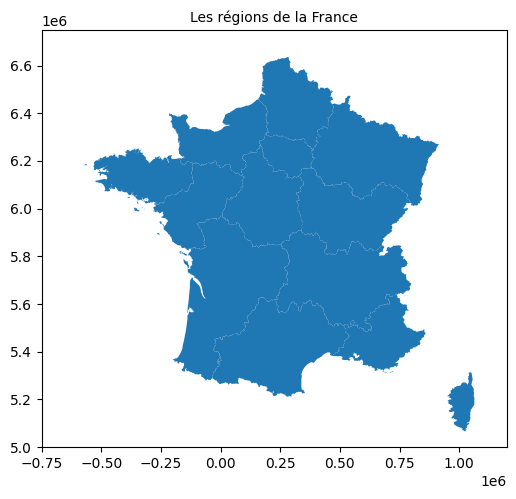

In [4]:
#REPRESENTATION 

if france.crs.to_string() != "EPSG:3857":
    france = france.to_crs(epsg=3857)
#Les  limites de la carte
xmin, xmax = -0.75e6, 1.2e6  # Convertir les limites en mètres (EPSG:3857)
ymin, ymax = 5e6, 6.75e6

#Ploting
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
france.plot(ax=ax)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.title("Les régions de la France", fontsize=10)
plt.show()


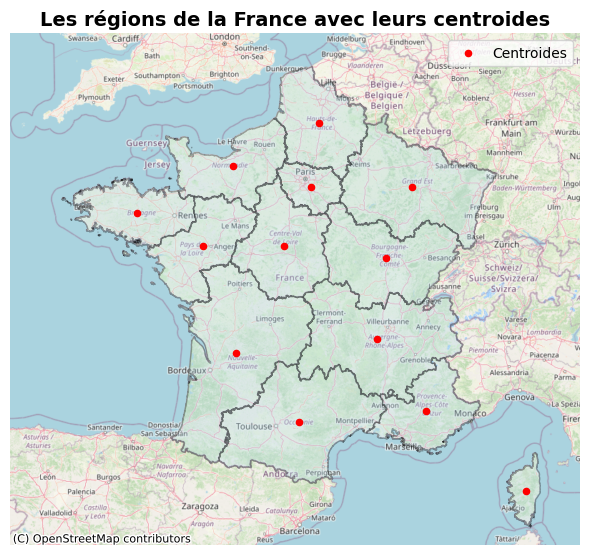

In [5]:
#Représentation des centroides 
france['centroid'] = france.geometry.centroid
france['longitude'] = france.centroid.x
france['latitude'] = france.centroid.y
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
france.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.3, color='lightblue')
ax.scatter(france['longitude'], france['latitude'], color='red', s=20, label='Centroides')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=france.crs)
plt.title("Les régions de la France avec leurs centroides", fontsize=14, fontweight='bold')
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()